In [1]:
import os, collections

if not os.path.exists('CIFAR10_data'):
    
    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !mkdir CIFAR10_data
    !tar -xf cifar-10-python.tar.gz -C CIFAR10_data

from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from utils import unpickle, preprocess, batch_run, pixel_range
from deepexplain.tensorflow import DeepExplain
from models import CIFAR_CNN
from trainer import Trainer

datadir = 'CIFAR10_data/cifar-10-batches-py/'
batches_train = sorted([datadir + batch for batch in os.listdir(datadir) if 'data_batch' in batch], key=lambda x: int(x[-1]))
batch_test = datadir + 'test_batch'

logdir = 'tf_logs/standard/'

In [2]:
for i in tqdm(range(5)):
    
    batch = unpickle(batches_train[i])

    if i == 0:
        data = batch[b'data'].astype(np.float32)
        cifar = np.transpose(np.reshape(data, [-1,3,32,32]), [0,2,3,1])
        labels = batch[b'labels']
    else:
        data = batch[b'data'].astype(np.float32)
        cifar = np.concatenate((cifar, np.transpose(np.reshape(data, [-1,3,32,32]), [0,2,3,1])), axis=0)
        labels = np.concatenate((labels, batch[b'labels']), axis=0)

test_batch = unpickle(batch_test)
cifar_test = np.transpose(np.reshape(test_batch[b'data'], [-1,3,32,32]), [0,2,3,1])
labels_test = np.array(test_batch[b'labels'])

# Set random seed so I don't have to retrain every time
np.random.seed(100)
random_mask = np.random.randint(low=0, high=255, size=[1,10,10,3])
cifar[:,:10,:10,:] = random_mask
cifar_test[:,:10,:10,:] = random_mask

data_train = (cifar / 127.5 - 1.0, labels)
data_test = (cifar_test / 127.5 - 1.0, labels_test)

label_map = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


### Training with Occluded Dataset

In [3]:
tf.reset_default_graph()

DNN = CIFAR_CNN(logdir, 'CNN')

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

trainer = Trainer(sess, DNN, data_train)
trainer.train(n_epochs=20, p_epochs=5)

test_acc = DNN.evaluate(sess, data_test)
print('Test Accuracy : {:.5f}'.format(test_acc))

sess.close()

Epoch : 5   | Loss : 0.44810 | Train Accuracy : 0.84166
Epoch : 10  | Loss : 0.13555 | Train Accuracy : 0.95238
Epoch : 15  | Loss : 0.06766 | Train Accuracy : 0.97640
Epoch : 20  | Loss : 0.05823 | Train Accuracy : 0.98040
Test Accuracy : 0.72050


### Comparing Amount of Attribution in Random Patch

INFO:tensorflow:Restoring parameters from tf_logs/standard/model
Running RectGrad explanation method
Running RectGrad PRR explanation method
Running Saliency Map explanation method
Running Guided BP explanation method
Running SmoothGrad explanation method
Running Gradient * Input explanation method
Running IntegGrad explanation method
Running DeepLIFT explanation method
Done!


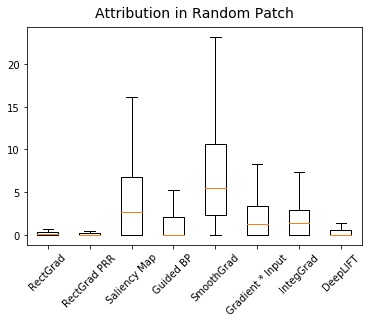

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

with DeepExplain(session=sess, graph=sess.graph) as de:
        
    new_saver = tf.train.import_meta_graph(logdir + 'model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint(logdir))
    
    X = tf.get_collection('tensors')[0]
    logits = tf.get_collection('tensors')[1]
    yv = tf.reduce_max(logits, 1)
    yi = tf.argmax(logits, 1)

    heavy_methods = ['SmoothGrad', 'IntegGrad', 'DeepLIFT']

    attribution_methods = [
                           ('RectGrad'         , 'rectgrad'),
                           ('RectGrad PRR'     , 'rectgradprr'),
                           ('Saliency Map'     , 'saliency'),
                           ('Guided BP'        , 'guidedbp'),
                           ('SmoothGrad'       , 'smoothgrad'),
                           ('Gradient * Input' , 'grad*input'),
                           ('IntegGrad'        , 'intgrad'),
                           ('DeepLIFT'         , 'deeplift')
                          ]

    attribution_methods = collections.OrderedDict(attribution_methods)
    
    attributions = collections.OrderedDict()
    
    for k, v in attribution_methods.items():
        
        print('Running {} explanation method'.format(k))
        
        if k in heavy_methods:
            batch_size = 500
        else:
            batch_size = 1000
        
        attribution = batch_run(lambda x: de.explain(v, yv, X, x), data_test[0], batch_size)
        
        if 'RectGrad' in k:
            attribution = np.where(attribution > 0, attribution, 0.0)
            attributions[k] = preprocess(attribution, 0, 100)
        else:
            attributions[k] = preprocess(attribution, 95, 100)
    
    print('Done!')

# Plotting
noise = [np.sum(v[:,:8,:8], axis=(1,2)) for v in attributions.values()]

plt.figure()
plt.boxplot(noise, showfliers=False)
plt.xticks(np.arange(1, 9), attributions.keys(), rotation=45, ha='center')
plt.title('Attribution in Random Patch', fontsize=14, pad=10)
plt.show()